### Cab-Driver Agent

In [29]:
#pip install --upgrade tensorflow-gpu --user


In [30]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam


# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [31]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [32]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())

<class 'numpy.ndarray'>
11.0
0.0


#### Tracking the state-action pairs for checking convergence


In [33]:
def Q_state(state):
    return ('-'.join(str(i) for i in state)).replace('nan','x')

In [34]:
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)


In [35]:
def initialise_tracking_states(): 
    sample_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2))] 
    #select 4 Q-values 
    for q_value in samvalues: 
        state = Q_state(q_value[0]) 
        action = q_value[1] 
        states_track[state][action] = []

In [36]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])
                

In [37]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [38]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01 
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = 0.99 
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            if(len(possible_actions_index) == 0):
                return 2
            else:
                
                return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            
            return possible_actions_index[np.argmax(q_vals_possible)]             


    def append_sample(self, state, action, reward, next_state,done):
        
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminals = [],[],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                terminals.append(terminal)
  
                
                # Write your code from here
                # 1. Predict the target from earlier model
            target = self.model.predict(update_input)  
            
            
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)    
                
                #3. Update your 'update_output' and 'update_input' batch
            
            for i in range(self.batch_size):
                if terminals[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
        # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

    def save(self, name):
        self.model.save(name)

In [39]:
Episodes = 1000

### DQN block

In [40]:
import time

In [41]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7
#  environment
env = CabDriver()

# get size of state and action from environment
state_size = 36
action_size = len(env.action_space)   

In [42]:
# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(action_size=action_size, state_size=state_size)
start_time = time.time()
score_tracked = []

# to store rewards in each episode
rewards_per_episode, episodes = [], []
rewards_init_state = []


for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    score = 0 
    terminal_state = False
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    #Call the DQN agent
    
    total_time = 0
    while not terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        # get action for the current state and take a step in the environment
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        
        action = agent.get_action(state, possible_actions_indices, actions)    
        reward, next_state, step_time = env.step(state, action, Time_matrix)
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            terminal_state = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state


    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

   # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)
        

C:\Users\chakr\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Saving Model 0
INFO:tensorflow:Assets written to: model_weights.pkl\assets
episode 9, reward 98.0, memory_length 1111, epsilon 7405.587041670228 total_time 728.0
episode 19, reward -11.0, memory_length 2000, epsilon 147596093.05304542 total_time 721.0
episode 29, reward -142.0, memory_length 2000, epsilon 2941644809782.7095 total_time 726.0
episode 39, reward -313.0, memory_length 2000, epsilon 5.862807075666679e+16 total_time 721.0
episode 49, reward -424.0, memory_length 2000, epsilon 1.1684791682591439e+21 total_time 730.0
episode 59, reward -57.0, memory_length 2000, epsilon 2.3288222672759923e+25 total_time 726.0
episode 69, reward 71.0, memory_length 2000, epsilon 4.641429047161015e+29 total_time 723.0
episode 79, reward 46.0, memory_length 2000, epsilon 9.250540027268047e+33 total_time 728.0
episode 89, reward 228.0, memory_length 2000, epsilon 1.8436668949713015e+38 total_time 727.0
episode 99, reward 167.0, memory_length 2000, epsilon 3.674496418148006e+42 total_time 731.0
epi

<ipython-input-42-f671fdd0e182>:66: RuntimeWarning: overflow encountered in exp
  agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)


episode 719, reward 171.0, memory_length 2000, epsilon inf total_time 725.0
episode 729, reward -101.0, memory_length 2000, epsilon inf total_time 721.0
episode 739, reward 63.0, memory_length 2000, epsilon inf total_time 726.0
episode 749, reward -109.0, memory_length 2000, epsilon inf total_time 723.0
episode 759, reward -28.0, memory_length 2000, epsilon inf total_time 722.0
episode 769, reward -8.0, memory_length 2000, epsilon inf total_time 724.0
episode 779, reward 266.0, memory_length 2000, epsilon inf total_time 725.0
episode 789, reward 181.0, memory_length 2000, epsilon inf total_time 723.0
episode 799, reward 70.0, memory_length 2000, epsilon inf total_time 723.0
episode 809, reward -269.0, memory_length 2000, epsilon inf total_time 724.0
episode 819, reward -148.0, memory_length 2000, epsilon inf total_time 721.0
episode 829, reward -26.0, memory_length 2000, epsilon inf total_time 721.0
episode 839, reward -111.0, memory_length 2000, epsilon inf total_time 732.0
episode 84

In [45]:
agent.save(name="model_weights.pkl")

INFO:tensorflow:Assets written to: model_weights.pkl\assets


### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [43]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

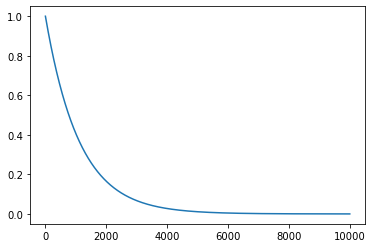

In [44]:
plt.plot(time, epsilon)
plt.show()